In [1]:
from PIL import Image
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import torchvision
from torchvision import transforms
from glob import glob
import cv2
import random

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,plot_confusion_matrix

import time
import copy

In [2]:
def seed(seed = 42):
    random.seed(seed) # python random seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed) # os 자체의 seed 고정
    np.random.seed(seed) # numpy seed 고정 
    torch.manual_seed(seed) # torch seed 고정
    torch.cuda.manual_seed(seed) # cudnn seed 고정
    torch.backends.cudnn.deterministic = True # cudnn seed 고정(nn.Conv2d)
    torch.backends.cudnn.benchmark = False # CUDA 내부 연산에서 가장 빠른 알고리즘을 찾아 수행

## DataLoader worker에 대한 seed 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed()

In [4]:
train_normal_path = '/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/normal_train_v3/*.jpg'
train_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/abnormal_train_v3/*.jpg'
valid_normal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/normal_val_v3/*.jpg'
valid_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/abnormal_val_v3/*.jpg'
test_normal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/normal_test_v3/*.jpg'
test_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/abnormal_test_v3/*.jpg'

In [5]:
train_normal_glob = glob(train_normal_path)
train_abnormal_glob = glob(train_abnormal_path)
val_normal_glob = glob(valid_normal_path)
val_abnormal_glob = glob(valid_abnormal_path)
test_normal_glob = glob(test_normal_path)
test_abnormal_glob = glob(test_abnormal_path)

print('train_normal :', len(train_normal_glob))
print('val_normal :', len(val_normal_glob))
print('test_normal :', len(test_normal_glob))
print('------------------------------------')
print('train_abnormal :', len(train_abnormal_glob))
print('val_abnormal :', len(val_abnormal_glob))
print('test_abnormal :', len(test_abnormal_glob))

train_normal : 472
val_normal : 52
test_normal : 66
------------------------------------
train_abnormal : 259
val_abnormal : 33
test_abnormal : 39


In [6]:
print(os.getcwd())

/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/base_seed


In [7]:
class Aov_Dysplasia_dataset(Dataset):
    def __init__(self, normal_path, abnormal_path, transform=None):
        #생성자, 데이터를 전처리 
        self.normal_path_list = glob(normal_path)
        self.abnormal_path_list = glob(abnormal_path)
        print(len(self.normal_path_list))
#         self.mode = mode 
    
#         label = np.array([[0, 1], [1, 0]], dtype=np.float32)
        
#         self.label_list = []
#         for i in self.normal_path_list:
#             self.label_list.append(label[0])
            
#         for i in self.abnormal_path_list:
#             self.label_list.append(label[1])
            
        label_policy = {
            'normal': 0, 
            'abnormal': 1
        }
    
        self.label_list= []
        
        for i in self.normal_path_list:
            self.label_list.append(label_policy["normal"])
            
        for i in self.abnormal_path_list:
            self.label_list.append(label_policy["abnormal"])
        
        self.total_img_path_list = self.normal_path_list + self.abnormal_path_list
        self.transform = transform
    
    def __len__(self):
        return len(self.total_img_path_list)
    
    def __getitem__(self, idx):
        
        img = cv2.imread(self.total_img_path_list[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #들어오는 이미지의 컬러 형태가 BGR인지 RGB인지 모르기때문에 변형
        img = np.array(img, dtype=np.float32)
        img = (img - np.min(img)) / (np.max(img)-np.min(img))
        
        label = self.label_list[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            
            return {'img': transformed['image'], 'label': label, 'filename': self.total_img_path_list[idx]}
        
        else:
            return{'img': img, 'label': label}

In [8]:
#https://albumentations.ai/docs/api_reference/augmentations/transforms/
import albumentations as A 
from  albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        # Contrast Limited Adaptive Histogram Equalization 적용
#     A.CLAHE(p=1,clip_limit=(1, 3)),
#     A.HorizontalFlip(p=0.3),
    A.Resize(224,224, interpolation = cv2.INTER_AREA),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.1, 0.2), rotate_limit=0, p=0.5, border_mode=cv2.BORDER_REPLICATE),
    A.RandomRotate90(p=0.7),
    A.VerticalFlip(p=0.7),
    A.HorizontalFlip(p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.3),
    ToTensorV2()
    ])

valid_transform = A.Compose(
    [
        A.Resize(224,224, interpolation = cv2.INTER_AREA),
        ToTensorV2()
    ])

test_transform = A.Compose(
    [
        A.Resize(224,224, interpolation = cv2.INTER_AREA),
        ToTensorV2()
    ])

In [9]:
train_dataset = Aov_Dysplasia_dataset(train_normal_path, train_abnormal_path, transform = train_transform)
valid_dataset = Aov_Dysplasia_dataset(valid_normal_path, valid_abnormal_path, transform = valid_transform)
test_dataset = Aov_Dysplasia_dataset(test_normal_path, test_abnormal_path, transform = test_transform)

472
52
66


In [10]:
# 각 dataset에서의 label값만 추출
train_label_count = []
for i in range(len(train_dataset)):
    label = train_dataset[i]['label']
    train_label_count.append(label)
    
print(len(train_label_count))

sum_train = len(train_label_count)


train_0_counts = train_label_count.count(0)
train_1_counts = train_label_count.count(1)

print('train label 0 :', train_0_counts)
print('train label 1 :',train_1_counts)

#클래스별 가중치 부여 => class 1에 가중치 높게 부여하게 됨
train_0_weight = []
train_1_weight = []
train_weight = []

train_0_weight.append(sum_train / train_0_counts) 
train_1_weight.append(sum_train / train_1_counts)

train_weight = train_0_weight + train_1_weight

print(train_weight)



731
train label 0 : 472
train label 1 : 259
[1.548728813559322, 2.8223938223938223]


In [11]:
train_label_count

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [12]:
# 해당 데이터의 label에 해당되는 가중치
weights = [train_weight[train_label_count[i]] for i in range(int(sum_train))] #해당 레이블마다의 가중치 비율
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(sum_train))

In [13]:
weights

[1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,
 1.548728813559322,


In [14]:
#dataloader 생성
batch_size= 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, worker_init_fn=seed_worker)
train_dataloader_no = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, worker_init_fn=seed_worker)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle = True, worker_init_fn=seed_worker)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False ,worker_init_fn=seed_worker)

In [15]:
print('train_dataset :',len(train_dataset))
print('valid_dataset :',len(valid_dataset))
print('test_dataset :',len(test_dataset))

train_dataset : 731
valid_dataset : 85
test_dataset : 105


In [16]:
a= 0

for data in train_dataloader:
    print(data['label'])
    a+=1        
    
    if a == 10:
        break

tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])


In [17]:
len(train_dataloader)

46

1
<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0.2654902  0.29215688 0.30282354]
  [0.75647056 0.75866663 0.7709019 ]
  [0.04501961 0.05223529 0.05811765]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.316      0.29184315 0.30282354]
  [0.75662744 0.74439216 0.7550588 ]
  [0.03294118 0.03686275 0.0414902 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.35301962 0.29709807 0.38007843]
  [0.7083922  0.69498044 0.75458825]
  [0.02627451 0.03215687 0.06996079]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]



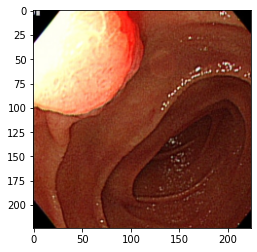

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[7.7207845e-01 7.7207845e-01 7.7207845e-01]
  [9.5764711e-02 9.5764711e-02 9.5764711e-02]
  [4.5490200e-03 4.5490200e-03 4.5490200e-03]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[5.5027455e-01 5.5027455e-01 5.5027455e-01]
  [4.7992155e-01 4.7992155e-01 4.7992155e-01]
  [1.2549019e-02 1.2549019e-02 1.2549019e-02]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[2.6996079e-01 2.6996079e-01 2.6996079e-01]
  [7.6745099e-01 7.6745099e-01 7.6745099e-01]
  [3.8352944e-02 3.8352944e-02 3.8352944e-02]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 ...

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.00000

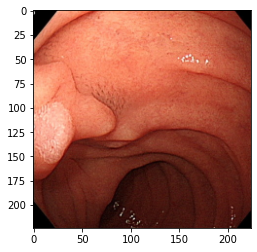

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[6.7984319e-01 6.7984319e-01 6.7984319e-01]
  [2.3294118e-01 2.3294118e-01 2.3294118e-01]
  [5.4117646e-03 5.4117646e-03 5.4117646e-03]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[6.1333332e-02 6.1333332e-02 6.1333332e-02]
  [2.8235295e-03 2.8235295e-03 2.8235295e-03]
  [1.1843138e-02 1.1843138e-02 1.1843138e-02]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[9.9607855e-03 9.9607855e-03 9.9607855e-03]
  [1.2078432e-02 1.2078432e-02 1.2078432e-02]
  [2.9019609e-03 2.9019609e-03 2.9019609e-03]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 ...

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.00000

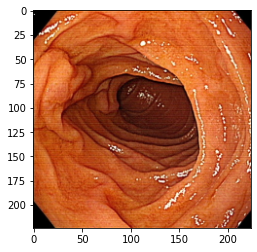

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(1)


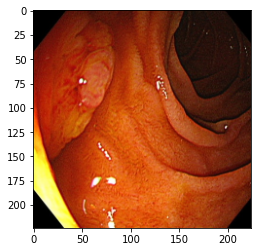

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


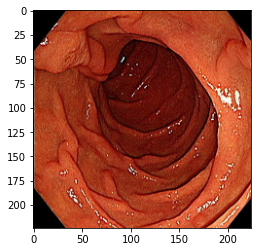

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


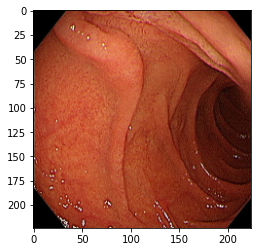

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0.7813333  0.7813333  0.7813333 ]
  [0.10854902 0.10854902 0.10854902]
  [0.01105882 0.01105882 0.01105882]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.5615686  0.5615686  0.5615686 ]
  [0.47309807 0.47309807 0.47309807]
  [0.01215686 0.01215686 0.01215686]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.27913728 0.27913728 0.27913728]
  [0.7614902  0.7614902  0.7614902 ]
  [0.04031373 0.04031373 0.04031373]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [

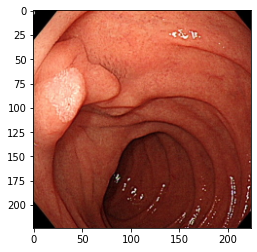

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


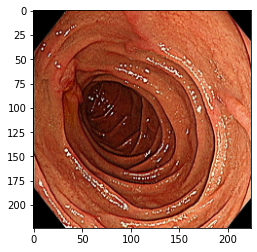

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


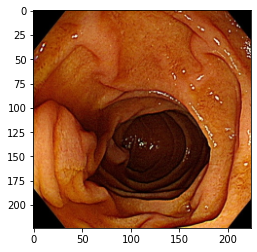

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


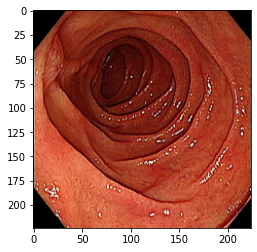

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(1)


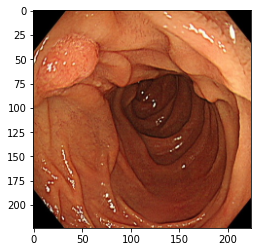

<built-in method type of Tensor object at 0x7f4e5c72b598>
(224, 224, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tensor(0)


KeyboardInterrupt: 

In [18]:
import os
import cv2
import numpy as np

#이미지를 numpy형식으로 바꾸어주고 transpose를 통해 수정해주는 과정을 람다형식으로 정의
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1)
for batch_idx, i in enumerate(valid_dataloader):
    print(batch_idx+1)
    for a in range(batch_size):
        img = i['img']
        label = i['label']
        print(label.type)
#         filename = i['filename']
        #     filename = i['filename']
        img = fn_tonumpy(img)[a]
        #     print(filename)
        print(img.shape)
        print(img)
#         print(filename[a])
        print(label[a])
        plt.imshow(img)
        plt.show()

In [18]:
from torchvision import models
import torch

resnet50_pretrained = models.resnet50(pretrained=True)
print(resnet50_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
num_classes = 1
num_features = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(num_features, num_classes)

resnet50_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
GPU_NUM = 0
os.environ["CUDA_VISIBLE_DEVICES"]='1'
print('gpu? ', torch.cuda.is_available())
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Current gpu: ', torch.cuda.current_device())

if device.type == 'cuda':
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')
    
model = resnet50_pretrained.to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output)

gpu?  True
Current gpu:  0
Allocated: 0.0 GB
Cached:    0.0 GB


/home/crop2292/anaconda3/envs/hoon/lib/python3.6/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


tensor([[0.5796],
        [0.3027],
        [0.3701]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [23]:
#summary(model, (3, 409, 465), device=device.type)

In [21]:
# 손실함수 정의(loss function) 
# 크로스 엔트로피 : 실제 값과 예측 값의 차이를 줄이기 위한 엔트로피
# 다중 클래스 문제에서 잘 작동
# loss_func = nn.BCEWithLogitsLoss()


# 옵티마이저 : Adam 
# model(신경망) 파라미터를 optimizer에 전달해줄 때 nn.Module의 parameters() 메소드를 사용
# Karpathy's learning rate 사용 (3e-4)
opt = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.75):
        super(FocalLoss, self).__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = self.loss_fn.reduction  # mean, sum, etc..

    def forward(self, pred, true):
        bceloss = self.loss_fn(pred, true)

        pred_prob = torch.sigmoid(pred)  # p  pt는 p가 true 이면 pt = p / false 이면 pt = 1 - p
        alpha_factor = true * self.alpha + (1-true) * (1 - self.alpha)  # add balance
        modulating_factor = torch.abs(true - pred_prob) ** self.gamma  # focal term
        loss = alpha_factor * modulating_factor * bceloss  # bceloss에 이미 음수가 들어가 있음
        
        if self.reduction == 'mean':
            return loss.mean()
        
        elif self.reduction == 'sum':
            return loss.sum()
        
        else:  # 'none'
            return loss

In [21]:
def metric_batch(output, target):
    #max함수 안의 1 : 어느방향으로 max값을 찾을지를 의미. 
    output_sig = torch.sigmoid(output)
    y_pred = output_sig.cpu()
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    
    preds_batch_list = []
    y_pred_list = y_pred.detach().cpu().numpy().tolist()
    preds_batch_list.append(y_pred_list)
    
    labels_batch_list =[]
    labels_list = target.detach().cpu().numpy().tolist()
    labels_batch_list.append(labels_list)
    
    correct_num = y_pred.eq(target.cpu()).int().sum()
    
    # https://junstar92.tistory.com/121
    #https://bigdatadiary0819.tistory.com/54
#     corrects = pred.eq(target).sum().item()
    return correct_num, preds_batch_list,labels_batch_list


# function to calculate loss per mini-batch
def loss_batch(output, target, opt=None):
    
    
#     target = torch.FloatTensor(target)
#     print(output)
#     print(target)
    

# 여기서 target값은 1차원이기 때문에 마지막 layer에서 나오는 결과를 1개의 출력으로
    fl_loss = FocalLoss().forward(output, target)
    metric_b, preds_batch_list,labels_batch_list = metric_batch(output, target)

#     배치 사이즈 만큼의 데이터가 들어가서 forward train을 하고 backward로 
#     optimize를 진행합니다. 이게 1step 
#     step마다 계산된 가중치를 다시 제로로 만들고 다음 배치 데이터를 
#     forward/backward해야 하므로 optimizer.zero_grad를 꼭 넣어준다.
    if opt is not None:
        opt.zero_grad()
        fl_loss.backward()
        opt.step()

    return fl_loss.item(), metric_b, preds_batch_list,labels_batch_list

In [22]:
def loss_epoch(model, dataset_dl, sanity_check=False, opt=None):
    #sanity_check가 true인 경우 1epoch만 학습하고 더이상 학습하지 않는다.
    running_loss = 0.0
    running_metric = 0.0
    len_dataset_dl = len(dataset_dl)
    len_dataset = len(dataset_dl.dataset)
    preds_running_list = []
    labels_running_list = []
#     print(len_data)
#     print(len(dataset_dl))
    
    
    for data in dataset_dl:
#         inputs = data
#     for a in range (i):
        inputs = data['img']
#         print(inputs.shape)
        labels = data['label']
#         print(labels.shape)
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        output = torch.squeeze(model(inputs))
    
#     for i, data in enumerate(dataset_dl):
#         inputs = data
#      for a in range (i):
#         inputs = data['img']
#          print(inputs.shape)
#         labels = data['label']
#          print(labels.shape)
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         output = model(inputs)

#         print(inputs.type)
#         print(output.type)
#         print(labels.type)
        
        
        loss_b, metric_b, preds_batch_list,labels_batch_list = loss_batch(output, labels, opt)

        running_loss += loss_b
        preds_running_list.extend(preds_batch_list)
        labels_running_list.extend(labels_batch_list)

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break
            
    average_loss = running_loss / len_dataset_dl
    average_metric = running_metric / len_dataset
#     print(average_loss)
    
    return average_loss, average_metric, preds_running_list, labels_running_list      

In [23]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
#     lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    #가장 잘 나온 weight를 저장.
    best_model_wts = copy.deepcopy(model.state_dict())

    #This is useful for finding lowest values for something.
    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric, preds_train_list, labels_train_list = loss_epoch(model, train_dl, sanity_check, opt)
        #epoch마다 loss값과 정확도 값 확인
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
        # confusion matrix를 그리기 위해 label과 prediction한 결과를 한곳으로 모아주기
        preds_train_list_sum = sum(preds_train_list,[])
        labels_train_list_sum = sum(labels_train_list,[])
        
# model.eval() : 해당 모델의 모든 레이어가 evaluation model에 들어가게 해주는 것. 
# 학습할 때만 필요한 dropout, batchnorm등의 기능을 비황성화 시키는 것.
# torch.no_grad() : gradient계산 context를 비활성화 해주는 역할.    
        model.eval()
    
        # valid data
        with torch.no_grad():
            val_loss, val_metric, preds_val_list, labels_val_list = loss_epoch(model, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
            print('Get best val_loss')

#         lr_scheduler.step(val_loss)


        train_accuracy = 100*train_metric
        val_accuracy = 100*val_metric
        
        writer.add_scalar('Loss/train', train_loss, epoch+1)
        writer.add_scalar('Loss/val', val_loss, epoch+1)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch+1)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch+1)
        
        print('train loss: %.6f , accuracy: %.2f, time: %.4f min' %(train_loss, train_accuracy, (time.time()-start_time)/60))
        print('val loss: %.6f , accuracy: %.2f, time: %.4f min' %(val_loss, val_accuracy, (time.time()-start_time)/60))
        
        preds_val_list_sum = sum(preds_val_list, [])
        labels_val_list_sum = sum(labels_val_list, [])
#         print(preds_val_list)
#         print(len(preds_val_list))
#         print(labels_val_list)
#         print(len(labels_val_list))
        
        print('train_confusion_matrix')
        print(confusion_matrix(labels_train_list_sum,preds_train_list_sum))
        print('val_confustion_matrix')
        print(confusion_matrix(labels_val_list_sum,preds_val_list_sum))
        print(classification_report(labels_val_list_sum,preds_val_list_sum))
        print(accuracy_score(labels_val_list_sum,preds_val_list_sum))
        print('-'*30)

        model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [24]:
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'train_dl':train_dataloader,
    'val_dl':valid_dataloader,
    'sanity_check':False,
#     'lr_scheduler':lr_scheduler,
    'path2weights':'/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/weights_file/Resnet50(b=16,Adam,Focal_alpha(0.8),WRS,seed)_weights_pt',
}

#만약 파일이 존재하지 않으면 새로운 파일 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('Resnet_weights_pt')

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/runs/Resnet50(b=16,Adam,Focal_alpha(0.8),WRS,seed)')

In [26]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 1/100, current lr=0.0001
Copied best model weights!
Get best val_loss
train loss: 0.036069 , accuracy: 73.05, time: 0.3672 min
val loss: 0.033933 , accuracy: 78.82, time: 0.3672 min
train_confusion_matrix
[[190 162]
 [ 35 344]]
val_confustion_matrix
[[46  6]
 [12 21]]
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.84        52
         1.0       0.78      0.64      0.70        33

    accuracy                           0.79        85
   macro avg       0.79      0.76      0.77        85
weighted avg       0.79      0.79      0.78        85

0.788235294117647
------------------------------
Epoch 2/100, current lr=0.0001
train loss: 0.020149 , accuracy: 82.76, time: 0.6443 min
val loss: 0.049932 , accuracy: 78.82, time: 0.6443 min
train_confusion_matrix
[[262  98]
 [ 28 343]]
val_confustion_matrix
[[49  3]
 [15 18]]
              precision    recall  f1-score   support

         0.0       0.77      0.94      0.84        52
         1

Text(0.5, 1.0, 'loss')

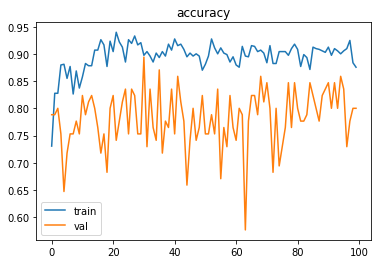

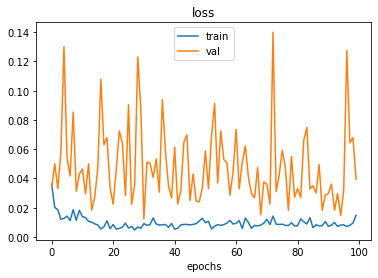

In [27]:
accuracy = metric_hist['train']
val_accuracy = metric_hist['val'] 

loss = loss_hist['train'] 
val_loss = loss_hist['val']

epochs = range(len(loss_hist['train']))

plt.plot(epochs, accuracy, label="train") 
plt.plot(epochs, val_accuracy, label="val") 
plt.legend() 
plt.title('accuracy') 

plt.figure() 
plt.plot(epochs, loss, label="train")
plt.xlabel('epochs')

plt.plot(epochs, val_loss, label="val") 
plt.xlabel('epochs')
plt.legend() 
plt.title('loss')

In [35]:
model_name = 'Resnet50(b=16,Adam,Focal_alpha(0.75),WRS,seed)_weights_pt'
model_path = '/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/weights_file/'

In [36]:
model = resnet50_pretrained.to(device)
model.load_state_dict(torch.load(model_path + model_name))

<All keys matched successfully>

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader.dataset)
pred = []
label = []
outputs = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model(inputs))
        
        output = torch.squeeze(model(inputs))
        output_sig = torch.sigmoid(output)
        outputs.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred.append(y_pred_)
        label.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


tensor([[-6.6700]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-5.2984]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-4.4466]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.8565]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-0.4270]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-0.0443]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-4.7403]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-2.3023]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.7596]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.7930]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.4607]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.9542]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.7921]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-2.6173]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-0.2465]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-1.5888]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-3.4093]], device='cuda:0')
0.0
tensor(1)
[0.0]
tensor([[-2.0612]], device='cud

In [38]:
from sklearn.metrics import roc_curve
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(label, outputs)

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

print(confusion_matrix(label,pred))
print(classification_report(label,pred))
cm = confusion_matrix(label,pred)

Best Threshold=0.468333, sensitivity = 0.821, specificity = 0.818, J=0.639
[[56 10]
 [ 9 30]]
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85        66
         1.0       0.75      0.77      0.76        39

    accuracy                           0.82       105
   macro avg       0.81      0.81      0.81       105
weighted avg       0.82      0.82      0.82       105



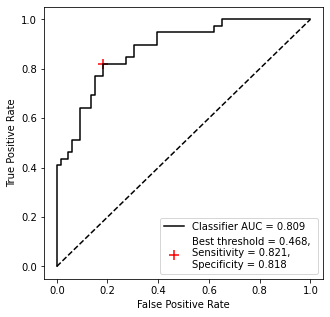

In [39]:
from sklearn.metrics import roc_auc_score

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="Classifier AUC = %.3f" % roc_auc_score(label, pred))
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

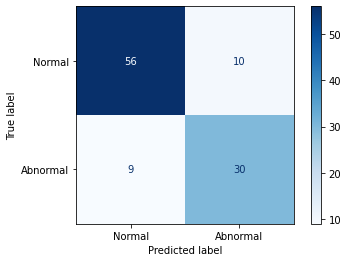

In [40]:
 from sklearn.metrics import ConfusionMatrixDisplay
# 라벨 설정
label_name = ['Normal', 'Abnormal'] 
disp = ConfusionMatrixDisplay(cm, # 분류 모델
                             display_labels=label_name, # 표에 표시할 labels
                             ) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
disp.plot(cmap = plt.cm.Blues)